Скачивание всех зависимостей проекта

In [7]:
!pip install -r requirements.txt

Авторизация в wandb 

In [14]:
!wandb login | cat wandb_secret.txt

"cat" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


Импорт библиотек

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
import keras 

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import pymorphy2
import Levenshtein
import gensim.downloader
import wandb
import json
import pickle
from os import path

import warnings
warnings.filterwarnings("ignore")

Чтение данных

In [16]:
# конфигурация
with open('config.json', 'r') as file:
    config = json.load(file)

cat = config['catboost']
nn = config['nn']
data_path = config['data_path']
inference_path = config["bins_directory"]

In [17]:
# датафрейм 
data = pd.read_csv(data_path, index_col=0)

Препроцессинг

In [18]:
# installing model
word2vec_rus = gensim.downloader.load('word2vec-ruscorpora-300')
word2vec_rus.save(path.join(inference_path, "word2vec_rus.model"))

In [19]:
morph = pymorphy2.MorphAnalyzer()

In [20]:
# get a part of speech needed to make an embedding of word
def get_part_of_speech(word):
    
    parsed_word = morph.parse(word)[0]
    pos = parsed_word.tag.POS

    if pos == "ADJF":
        return "ADJ"
    
    return pos 

In [21]:
# making embedding by pretrained word2vec model 
def get_embedding(word):

    w2v_word = f"{word}_{get_part_of_speech(word)}"

    try:
        emb = word2vec_rus[w2v_word]

    except KeyError:
        return None
    
    return emb

In [22]:
# add extra columns for embeddings 
for i in range(600):
    data[f"emb_{int(i > 299) + 1}_{i % 300}"] = 0
# add extra columns for Levenshtein distance
data["lev_dist"] = 0

rows_to_drop = []

# add embeddings to dataframe 
for i in range(len(data)):

    # get embs for two words
    word1 = data.word1[i]
    word2 = data.word2[i]
    emb1 = get_embedding(word1)
    emb2 = get_embedding(word2)

    if emb1 is not None and emb2 is not None:
        # add embeddings
        data.loc[i, "emb_1_0":"emb_1_299"] = emb1
        data.loc[i, "emb_2_0":"emb_2_299"] = emb2
        data.loc[i, "lev_dist"] = Levenshtein.distance(word1, word2)
        # print("YES", data.word1[i], data.word2[i])

    else: 
        # delete words that are not in word2vec vocabulary
        rows_to_drop.append(i)
        # print("NO", data.word1[i], data.word2[i])

data = data.drop(rows_to_drop, axis=0).reset_index(drop=True)
data.head()

,word1,word2,label,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,...,emb_2_291,emb_2_292,emb_2_293,emb_2_294,emb_2_295,emb_2_296,emb_2_297,emb_2_298,emb_2_299,lev_dist
0,целый,цельный,1,-0.019124,0.034811,0.057754,0.119841,-0.034180,0.042868,0.015424,...,0.032209,0.014659,0.024586,-0.071244,-0.106860,0.002109,0.057067,-0.029967,0.069121,2
1,сравнимый,неорганичный,0,-0.043983,-0.009047,-0.063538,0.147805,-0.161587,0.027221,0.032012,...,-0.034892,0.018441,0.069707,-0.001893,-0.062972,0.145138,0.147791,-0.062155,0.080968,7
2,чубастый,завоевательный,0,-0.051917,0.044872,0.014789,0.002823,-0.002203,0.050730,0.031053,...,0.046212,-0.020866,-0.080959,-0.085725,-0.003354,0.015747,0.017519,-0.042495,0.167213,11
3,обидчивый,азарт,0,0.023674,0.052748,-0.034327,-0.031669,-0.014316,0.073295,-0.061295,...,-0.039973,-0.012380,-0.012538,-0.200660,-0.089638,-0.017675,0.042906,-0.012042,-0.019632,9
4,личностный,личный,1,-0.045874,-0.051794,-0.059747,0.019997,-0.075421,-0.042737,-0.057829,...,0.022120,-0.057636,0.027975,-0.042808,-0.101067,0.031723,0.043072,-0.031811,0.032527,4


PCA сокращение размерности эмбедингов

In [23]:
# fitting PCA
def fit_pca(X, n):
    pca = PCA(n_components=n)
    pca.fit(X)
    with open(path.join(inference_path, 'pca_model.pkl'), 'wb') as file:
        pickle.dump(pca, file)
    return pca

# transform dataset to n_componets dimansion
def reduce_dimension(pca, X):
    X_transformed = pca.transform(X)
    return X_transformed

In [24]:
X = data.drop(["word1", "word2", "label"], axis=1)
y = data["label"]

pca_n_components = config["pca_n_components"]

# fit PCA
pca = fit_pca(pd.concat([X.loc[:, "emb_1_0":"emb_1_299"], X.loc[:, "emb_2_0":"emb_2_299"].rename(columns={f"emb_2_{i}":f"emb_1_{i}" for i in range(300)}) ], ignore_index=True), pca_n_components)

# reduce dimensuon with PCA
X.loc[:, "emb_1_0":f"emb_1_{pca_n_components-1}"] = reduce_dimension(pca, X.loc[:, "emb_1_0":"emb_1_299"])
X.loc[:, f"emb_2_0":f"emb_2_{pca_n_components-1}"] = reduce_dimension(pca, X.loc[:, "emb_2_0":"emb_2_299"].rename(columns={f"emb_2_{i}":f"emb_1_{i}" for i in range(300)}))

# drop extra columns of embedding
X = X.drop(list(X.columns[pca_n_components:300]) + list(X.columns[300+pca_n_components:-1]), axis=1)
X.head()

,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,emb_1_7,emb_1_8,emb_1_9,...,emb_2_141,emb_2_142,emb_2_143,emb_2_144,emb_2_145,emb_2_146,emb_2_147,emb_2_148,emb_2_149,lev_dist
0,0.092990,0.064130,-0.009231,-0.117479,0.119543,-0.012405,0.001261,0.036711,0.056210,0.036373,...,-0.012515,0.038739,-0.036974,0.030776,-0.042276,-0.013223,0.021696,-0.014643,-0.008482,2
1,-0.073190,0.121473,0.159301,-0.092436,-0.064992,0.211329,0.043878,-0.079575,0.139456,-0.007544,...,0.017741,0.036822,-0.005179,-0.041460,0.041814,-0.002438,0.018697,-0.011197,0.034190,7
2,0.404789,-0.048654,-0.008222,-0.030357,-0.002151,0.115745,-0.036572,0.107037,-0.181174,-0.009332,...,-0.043755,0.071218,-0.006994,-0.030376,-0.028320,-0.018306,0.002248,-0.002137,-0.057414,11
3,0.093875,-0.295198,-0.023503,0.178026,-0.329820,-0.137436,0.063094,-0.033621,-0.093354,-0.018633,...,0.029843,-0.052629,-0.076239,0.025841,-0.019057,0.007507,0.005572,-0.071429,-0.002006,9
4,-0.438857,-0.025888,0.076917,-0.048277,-0.095657,-0.114349,-0.050334,-0.016787,0.099323,-0.067111,...,0.008403,0.062636,-0.023796,0.052687,-0.023878,0.028928,-0.002740,0.034337,-0.001666,4


In [25]:
# PCA explained variance 
np.sum(pca.explained_variance_ratio_)

0.8156617089713074

Feature ingineering 

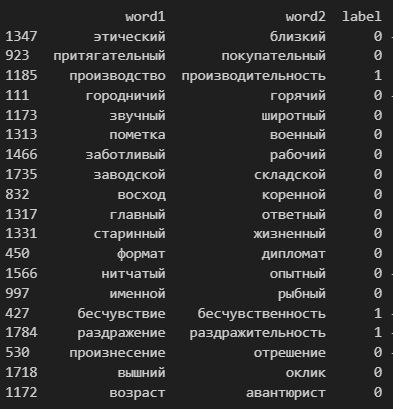

На одном из прогонов модели после вывода слов, в которых модель ошиблась, я заметил что модель часто допускает ошибку первого рода (ложноположительные объекты). Хотя по словам, в которых модель ошиблась, легко понять что они не паронимы, тк между ними большое расстояние Левенштейна. Возможно, модель не обращает достаточного внимания на слова с большим расстоянием Левенштейна, поэтому введем два новых признака

 - квадрат расстояния Левенштейна
 - процент добавленных символов (расстояние Левенштейна, деленое на максимальную длину слова)

In [29]:
X["lev_dist_2"] = X.lev_dist**2
X["lev_dist_%"] = 0
for i in range(len(data.word1)):
    X["lev_dist_%"][i] = X.lev_dist[i] / max(len(data.word1[i]), len(data.word2[i]))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Катбуст

In [31]:
if config["logging"]:
    wandb.init(project="paronyms", tags=["cat", "with dist 2", "with dist %"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kialimkhanov (paronyms). Use `wandb login --relogin` to force relogin


In [32]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10.0),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0)
    }

    model = CatBoostClassifier(verbose=0, **params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)

    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=cat["n_trials"])

best_params = study.best_params
cat_model = CatBoostClassifier(verbose=0, **best_params)
cat_model.fit(X_train, y_train)
best_predictions = cat_model.predict(X_test)
best_mae = mean_absolute_error(y_test, best_predictions)
predictions = cat_model.predict_proba(X_test)

print('Best Parameters:', best_params)
print('Best MAE:', best_mae)

[I 2024-04-02 16:23:03,896] A new study created in memory with name: no-name-3d90d1ed-8c5f-4b4e-a52a-6311992f2538
[I 2024-04-02 16:26:51,658] Trial 0 finished with value: 0.029891304347826088 and parameters: {'learning_rate': 0.011055607602454404, 'depth': 9, 'l2_leaf_reg': 0.1723043430446343, 'bagging_temperature': 0.4312752064990614}. Best is trial 0 with value: 0.029891304347826088.
[I 2024-04-02 16:27:29,662] Trial 1 finished with value: 0.029891304347826088 and parameters: {'learning_rate': 0.01626757927798775, 'depth': 6, 'l2_leaf_reg': 3.3788543496042287, 'bagging_temperature': 0.9453951260806027}. Best is trial 0 with value: 0.029891304347826088.
[I 2024-04-02 16:29:31,274] Trial 2 finished with value: 0.029891304347826088 and parameters: {'learning_rate': 0.027240818907993968, 'depth': 8, 'l2_leaf_reg': 0.1224364963631044, 'bagging_temperature': 0.01519011778294576}. Best is trial 0 with value: 0.029891304347826088.
[I 2024-04-02 16:29:54,164] Trial 3 finished with value: 0.03

Best Parameters: {'learning_rate': 0.03299162283846481, 'depth': 6, 'l2_leaf_reg': 0.13917825068857656, 'bagging_temperature': 0.07136822425889973}
Best MAE: 0.024456521739130436


In [33]:
treshold = cat["treshold"]

mae = mean_absolute_error(y_test, predictions[:, 1])
acc = accuracy_score(y_test, [1 if prob > treshold else 0 for prob in predictions[:, 1]])
print('MAE:', mae, ' Accuracy:', acc)

if config["logging"]:
    wandb.log({'MAE': mae, 'Accuracy': acc, "params": best_params.update({"pca_comp": config["pca_n_components"]})})
    wandb.finish()

MAE:

 0.03088106577016529  Accuracy: 0.9755434782608695


Accuracy,▁
MAE,▁
Accuracy,0.97554
MAE,0.03088


In [34]:
cat_model.save_model(path.join(inference_path, 'catboost_model.bin'))

In [35]:
# слова в которых модель ошиблась
errors = y_test != [1 if prob > treshold else 0 for prob in predictions[:, 1]]
words_with_errors = data.iloc[errors[errors==True].index]
print(words_with_errors[["word1", "word2", "label"]])

               word1           word2  label
923   притягательный   покупательный      0
111       городничий         горячий      0
548        иноверный  единоверческий      0
1466      заботливый         рабочий      0
1735       заводской       складской      0
694     почтительный    добровольный      0
940   реалистический     токсический      0
367        житейский       жизненный      1
530     произнесение       отрешение      0


In [38]:
# get feature importance
feature_importances = cat_model.feature_importances_

for i, importance in enumerate(feature_importances):
    print(f"{X.columns[i]}: {importance}")

emb_1_0: 0.3896652851559677
emb_1_1: 0.10581689641249965
emb_1_2: 0.25051706438724913
emb_1_3: 0.09266599383143491
emb_1_4: 0.6307559021503264
emb_1_5: 0.16797885731138518
emb_1_6: 0.04433726237353064
emb_1_7: 0.06326542891421301
emb_1_8: 0.04317801034743872
emb_1_9: 0.0011519069102150427
emb_1_10: 0.2329882221676286
emb_1_11: 0.006900148544668656
emb_1_12: 0.2291551257575417
emb_1_13: 1.4541089682773352
emb_1_14: 0.22696774492682212
emb_1_15: 0.04446299866498395
emb_1_16: 0.1722823272885171
emb_1_17: 0.15300412811291417
emb_1_18: 0.22787320636746014
emb_1_19: 0.20495464540003192
emb_1_20: 0.17138588875498778
emb_1_21: 0.17157398251486006
emb_1_22: 0.28314839582274764
emb_1_23: 0.08898666256913053
emb_1_24: 0.2066520028107423
emb_1_25: 0.07475986975593035
emb_1_26: 0.22755442738974657
emb_1_27: 0.14646380125034142
emb_1_28: 0.3011369811103429
emb_1_29: 0.09904508760527143
emb_1_30: 0.16590498003862034
emb_1_31: 0.18679421029830595
emb_1_32: 0.04877367715258769
emb_1_33: 0.1198623480520

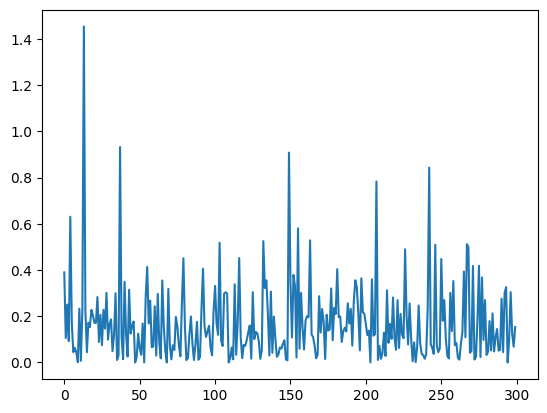

In [39]:
# plotting feature importance of embeddings
plt.plot(cat_model.feature_importances_[:-3])

Нейросеть

In [95]:
# Логирование
if config["logging"]:
    wandb.init(project="paronyms", tags=["nn", "with dist 2", "with dist %"])
    wandb.log(nn)

batch_size,▁
epochs,▁
lr,▁
pca_comp,▁
treshold,▁
batch_size,8
epochs,500
lr,0.05
optim,adagrad
pca_comp,150
treshold,0.5


In [96]:
nn_model = tf.keras.Sequential()

optimizer = keras.optimizers.Adam(learning_rate=nn["lr"])
# optimizer = keras.optimizers.Adagrad(learning_rate=nn["lr"], initial_accumulator_value=0.1) 
layers = nn["layers"]
activations = nn["activations"]

for i in range(len(layers)):
    if i == 0:
        nn_model.add(tf.keras.layers.Dense(layers[i], activation=activations[i], input_shape=(X_train.shape[1],)))
    else:
        nn_model.add(tf.keras.layers.Dense(layers[i], activation=activations[i]))

nn_model.compile(optimizer=optimizer, loss='mean_absolute_error')

history = nn_model.fit(X_train, y_train, epochs=nn["epochs"], batch_size=nn["batch_size"], verbose=0)

predictions = nn_model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


MAE: 0.05934618377739962  Accuracy: 0.9402173913043478


Accuracy,▁
MAE,▁
batch_size,▁
epochs,▁
lr,▁
treshold,▁
Accuracy,0.94022
MAE,0.05935
batch_size,8
epochs,100
lr,0.001


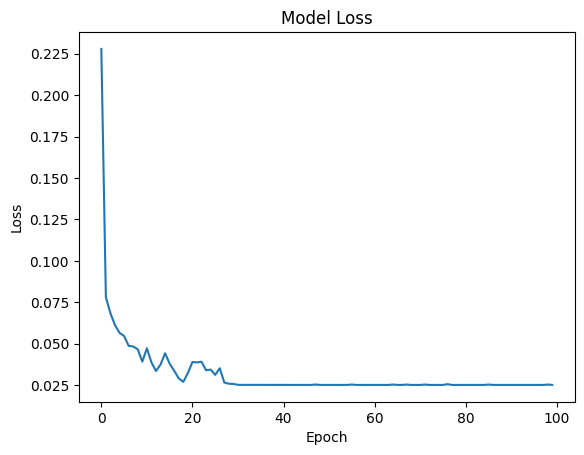

In [97]:
treshold = nn["treshold"]

mae = mean_absolute_error(y_test, predictions)
acc = accuracy_score(y_test, [1 if prob > treshold else 0 for prob in predictions])
print('MAE:', mae, ' Accuracy:', acc)

if config["logging"]:
    wandb.log({'MAE': mae, 'Accuracy': acc, "params": nn.update({"pca_comp": config["pca_n_components"], "optim": "adagrad"})})
    wandb.finish()

# Plotting the loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Тестирование

In [58]:
# function for testing new words
def test(word1, word2, model):

    # getting embs and lev dist 
    emb1, emb2 = get_embedding(word1), get_embedding(word2)
    pca_emb1 = reduce_dimension(pca, emb1.reshape(1, -1))
    pca_emb2 = reduce_dimension(pca, emb2.reshape(1, -1))
    lev_dist = Levenshtein.distance(word1, word2)

    # creating dataframe
    row = pca_emb1.tolist()[0] + pca_emb2.tolist()[0] + [lev_dist]
    X_new = pd.DataFrame([row], columns=X.columns)
    
    # predictions 
    if model == "cat":
        prediction = cat_model.predict_proba(X_new)
        res = np.argmax(prediction[0])
        proba = max(prediction[0])

    if model == "nn":
        prediction = nn_model.predict(X_new)
        if prediction[0][0] < 0.5:
            res = 0
            proba = 1 - (prediction[0][0] if prediction[0][0] > 0 else 0)
        else:
            res = 1
            proba = (prediction[0][0] if prediction[0][0] < 1 else 1)

    # result
    print(f"Слова {word1} и {word2} {'не '*(not res)}являются паронимами с вероятностью {proba}")

In [59]:
# не паронимы
word1 = "приветливый"
word2 = "страна" 

# паронимы
word1 = "целый"
word2 = "цельный" 

# модель 
model = "cat" # nn - keras nn, cat - catboostclassifier

# тестирование
test(word1, word2, model)

Слова целый и цельный являются паронимами с вероятностью 0.9995663900978244


In [ ]:
X.shape

Мусорка

In [ ]:
data

,word1,word2,label,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,...,emb_2_291,emb_2_292,emb_2_293,emb_2_294,emb_2_295,emb_2_296,emb_2_297,emb_2_298,emb_2_299,lev_dist
0,аккордовый,квадрат,0,-0.012578,0.071381,-0.066920,0.132629,0.039623,0.068954,-0.102715,...,0.012084,0.054774,0.012667,-0.049291,0.144537,-0.074161,-0.035057,0.081322,0.129544,0
1,целый,цельный,1,-0.019124,0.034811,0.057754,0.119841,-0.034180,0.042868,0.015424,...,0.032209,0.014659,0.024586,-0.071244,-0.106860,0.002109,0.057067,-0.029967,0.069121,0
2,женский,господний,0,0.044881,-0.092671,0.050879,-0.044229,0.011045,0.028815,-0.058337,...,0.073815,0.014237,0.103689,0.109344,0.009336,0.047421,0.005184,0.071654,-0.028561,0
3,обличительный,динамизм,0,0.066741,0.038244,0.027620,0.058278,0.048305,0.110592,-0.115581,...,-0.102109,0.129003,-0.052745,-0.043174,-0.039006,0.050456,-0.007910,-0.029959,0.016620,0
4,сыскать,снискать,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3511,гнилой,гнилостный,1,0.022569,-0.047862,0.049707,0.058395,0.006504,0.046971,0.035626,...,-0.091607,0.088824,0.001456,-0.006952,0.041889,0.050071,0.102235,-0.003491,-0.002087,0
3512,кормильщица,притягательный,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3513,абонемент,абонент,1,0.068919,0.042074,-0.030451,-0.087799,0.016597,-0.016370,0.019723,...,0.067424,0.100960,0.029388,-0.060928,0.016881,-0.025644,-0.061658,-0.017059,-0.043113,0
3514,беженец,выучить,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [ ]:
get_embedding(data['word1'][0])

array([-1.25777004e-02,  7.13808015e-02, -6.69195578e-02,  1.32629201e-01,
        3.96230109e-02,  6.89538270e-02, -1.02715276e-01, -2.07985435e-02,
       -4.17454605e-04, -6.66920096e-02,  1.85652584e-01, -1.44832075e-01,
        2.83512380e-02, -1.11901104e-01,  4.56056818e-02, -4.81510274e-02,
        8.36276039e-02, -9.19803232e-03,  9.81500838e-04,  5.74996658e-02,
       -2.92572589e-03,  6.52177706e-02, -4.75657806e-02,  4.61040102e-02,
       -3.82861830e-02,  5.70593216e-02, -3.37926932e-02,  1.21076353e-01,
       -1.81092322e-02,  9.62400343e-03, -1.48299234e-02,  1.01952113e-01,
        1.60059571e-01, -5.47798118e-03,  3.87733914e-02,  3.83970179e-02,
        1.25514701e-01, -8.64881873e-02,  2.29348727e-02, -2.13215649e-02,
       -1.91617105e-02, -1.42319629e-03, -1.11882702e-01, -8.07544217e-02,
       -5.52563854e-02,  1.29661132e-02, -3.10040861e-02, -4.55451086e-02,
        4.72736470e-02, -7.49781057e-02, -9.20100696e-03,  5.29071130e-02,
        6.45692181e-03,  

In [ ]:
morph = pymorphy2.MorphAnalyzer()

word = 'знамя_NOUN'
parsed_word = morph.parse(word)[0]
pos = parsed_word.tag.POS

print(pos)

None
